✅ Removed 0 highly correlated features.

Training Random Forest with Stratified K-Fold Cross-Validation...
Random Forest Average Accuracy: 0.9933 ± 0.0013

Training AdaBoost with Stratified K-Fold Cross-Validation...
AdaBoost Average Accuracy: 0.9986 ± 0.0001

--- Random Forest ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       1.00      0.98      0.99     14706

    accuracy                           1.00     71569
   macro avg       1.00      0.99      0.99     71569
weighted avg       1.00      1.00      1.00     71569

Accuracy: 0.9960
Training Time: 55.02 sec
AUC-ROC: 0.9960
Confusion Matrix:
[[56842    21]
 [  263 14443]]
Total Fraud Transactions in Dataset: 14706.0
Total Non-Fraud Transactions in Dataset: 56863.0
Fraud Transactions Identified by Random Forest: 14464.0
Non-Fraud Transactions Identified by Random Forest: 57105.0


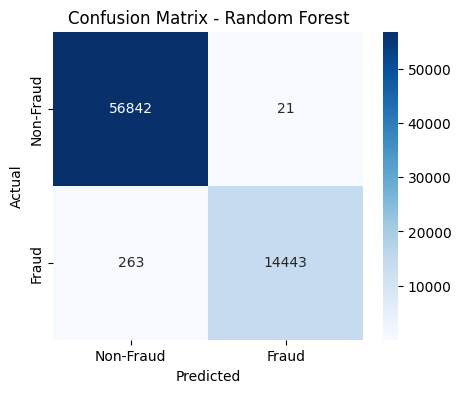


--- AdaBoost ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       1.00      0.99      1.00     14706

    accuracy                           1.00     71569
   macro avg       1.00      1.00      1.00     71569
weighted avg       1.00      1.00      1.00     71569

Accuracy: 0.9986
Training Time: 39.84 sec
AUC-ROC: 0.9986
Confusion Matrix:
[[56863     0]
 [  100 14606]]
Total Fraud Transactions in Dataset: 14706.0
Total Non-Fraud Transactions in Dataset: 56863.0
Fraud Transactions Identified by AdaBoost: 14606.0
Non-Fraud Transactions Identified by AdaBoost: 56963.0


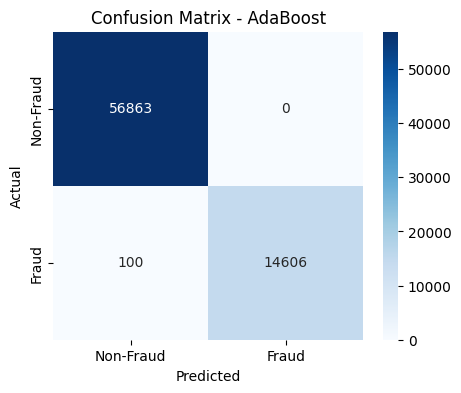


--- Ensemble ---
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     56863
         1.0       1.00      0.98      0.99     14706

    accuracy                           1.00     71569
   macro avg       1.00      0.99      0.99     71569
weighted avg       1.00      1.00      1.00     71569

Accuracy: 0.9951
Training Time: 98.76 sec
AUC-ROC: 0.9951
Confusion Matrix:
[[56863     0]
 [  350 14356]]
Total Fraud Transactions in Dataset: 14706.0
Total Non-Fraud Transactions in Dataset: 56863.0
Fraud Transactions Identified by Ensemble: 14356.0
Non-Fraud Transactions Identified by Ensemble: 57213.0


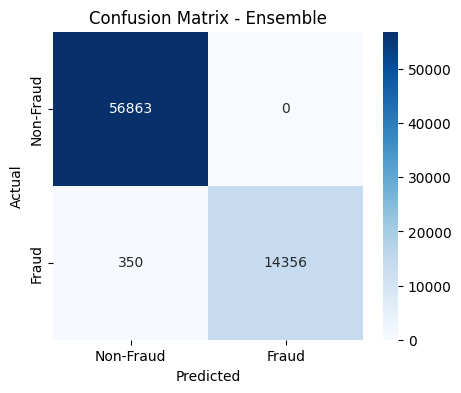

In [ ]:
# ========================================
# 1. Import Libraries
# ========================================
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE

from IPython.display import HTML, display, Markdown, Image

import warnings
warnings.filterwarnings('ignore')  # optional

# ========================================
# 2. Load Dataset
# ========================================
file_path = "C:/Users/penny/Downloads/ccfd/creditcard_2023.csv"
df = pd.read_csv(file_path)

# Target column detection
target_col = "Class" if "Class" in df.columns else df.columns[-1]
print(f" Target column used: {target_col}")

# Check initial fraud distribution
print("\n Full dataset fraud distribution:")
print(df[target_col].value_counts())

# ========================================
# 3. Feature Selection - Remove High Correlations
# ========================================
corr_matrix = df.drop(columns=[target_col]).corr()
high_corr_features = set()
threshold = 0.9

for col in corr_matrix.columns:
    for idx in corr_matrix.index:
        if abs(corr_matrix.loc[col, idx]) > threshold and col != idx:
            high_corr_features.add(col)

df = df.drop(columns=high_corr_features)
print(f" Removed {len(high_corr_features)} highly correlated features.")

# Drop NaN rows (if any) in target
df = df.dropna(subset=[target_col])

# ========================================
# 4. Train-Test Split
# ========================================
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========================================
# 5. Feature Scaling
# ========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========================================
# 6. KMeans Clustering as Feature
# ========================================
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_train_scaled)

train_clusters = kmeans.predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)

# Cluster-wise fraud probability
df_train = pd.DataFrame(X_train_scaled)
df_train['Cluster'] = train_clusters
df_train['Target'] = y_train.values

cluster_fraud_prob = df_train.groupby('Cluster')['Target'].mean()

# Add fraud probability feature
train_cluster_prob = np.array([cluster_fraud_prob[c] for c in train_clusters]).reshape(-1, 1)
test_cluster_prob = np.array([cluster_fraud_prob[c] for c in test_clusters]).reshape(-1, 1)

X_train_final = np.hstack((X_train_scaled, train_cluster_prob))
X_test_final = np.hstack((X_test_scaled, test_cluster_prob))

# ========================================
# 6.1 Apply SMOTE to Balance Classes
# ========================================
print("\n Applying SMOTE to balance training data...")
smote = SMOTE(random_state=42)
X_train_final, y_train = smote.fit_resample(X_train_final, y_train)
print(" SMOTE applied. New class distribution:")
print(pd.Series(y_train).value_counts())

# ========================================
# 7. Model Setup
# ========================================
rf = RandomForestClassifier(
    n_estimators=50, max_depth=4,
    min_samples_split=50, min_samples_leaf=25,
    class_weight="balanced_subsample",
    random_state=42
)

ada = AdaBoostClassifier(
    n_estimators=15, learning_rate=0.1,
    random_state=42
)

ensemble = VotingClassifier(
    estimators=[("Random Forest", rf), ("AdaBoost", ada)],
    voting='soft'
)

models = {
    "Random Forest": rf,
    "AdaBoost": ada,
    "Ensemble": ensemble
}

# ========================================
# 8. Cross Validation
# ========================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []

for name, model in {"Random Forest": rf, "AdaBoost": ada}.items():
    print(f"\n Cross-validating {name}...")
    scores = cross_val_score(model, X_train_final, y_train, cv=cv, scoring='accuracy')
    print(f"Average Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    cv_results.append((name, scores.mean(), scores.std()))

# ========================================
# 9. Model Training, Evaluation, Plotting & Saving Confusion Matrix
# ========================================
# Ensure 'uploads' folder exists
os.makedirs('uploads', exist_ok=True)

predictions = {}
metrics_table = []
cm_filenames = {
    "Random Forest": 'uploads/rf_cm.png',
    "AdaBoost": 'uploads/ab_cm.png',
    "Ensemble": 'uploads/ensemble_cm.png'
}

for name, model in models.items():
    print(f"\n========================\n{name}\n========================")

    start = time.time()
    model.fit(X_train_final, y_train)
    train_time = time.time() - start

    y_pred = model.predict(X_test_final)
    predictions[name] = y_pred

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {acc:.4f}")
    print(f"Training Time: {train_time:.2f} sec")
    print(f"Confusion Matrix:\n{cm}")

    # Confusion matrix heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Fraud", "Fraud"],
                yticklabels=["Non-Fraud", "Fraud"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    cm_filename = cm_filenames[name]
    plt.savefig(cm_filename)
    plt.close()

    try:
        display(Image(filename=cm_filename, width=400))
    except Exception as e:
        print(f"[Image Display Failed: {e}]")

    # ROC Curve
    y_score = model.predict_proba(X_test_final)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_final)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.figure()
    plt.plot(recall, precision, label=f"{name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.legend()
    plt.show()

    # Updated Transaction Summary
    true_frauds = sum(y_test)
    true_non_frauds = len(y_test) - true_frauds
    pred_frauds = sum(y_pred)
    correct_frauds = sum((y_test == 1) & (y_pred == 1))
    correct_non_frauds = sum((y_test == 0) & (y_pred == 0))

    summary_text = f"""
###  {name} – Transaction Summary
- Total Fraud Transactions in Dataset: {true_frauds}
- Total Non-Fraud Transactions in Dataset: {true_non_frauds}
- Fraud Transactions Identified Correctly by {name}: {correct_frauds}
- Non-Fraud Transactions Identified Correctly by {name}: {correct_non_frauds}
- Total Predicted as Fraud by {name}: {pred_frauds}
"""
print(summary_text)
display(Markdown(summary_text))
metrics_table.append((name, acc, report['1']['precision'], report['1']['recall'], report['1']['f1-score']))

# Show Metrics Table
metrics_df = pd.DataFrame(metrics_table, columns=['Model', 'Accuracy', 'Precision (Fraud)', 'Recall (Fraud)', 'F1-score (Fraud)'])
display(Markdown("## 📊 Model Comparison"))
display(metrics_df.set_index('Model'))

print("\n Confusion matrix images saved successfully!")

# ========================================
# 10. Save Outputs
# ========================================
# Save true labels
pd.DataFrame(y_test).to_csv('uploads/y_test.csv', index=False)

# Save predictions
pd.DataFrame(predictions["Random Forest"]).to_csv('uploads/rf_preds.csv', index=False)
pd.DataFrame(predictions["AdaBoost"]).to_csv('uploads/ab_preds.csv', index=False)
pd.DataFrame(predictions["Ensemble"]).to_csv('uploads/ensemble_preds.csv', index=False)

print("\n Predictions and true labels saved successfully!")
